In [4]:
%pip install torch

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 MB 26.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.9/171.9 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.2/133.2 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.8 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 22.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 33.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from scipy import stats
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

In [2]:
# Define the SVM model using PyTorch
class SVM(nn.Module):
    def __init__(self):
        super(SVM, self).__init__()
        self.linear = nn.Linear(28 * 28, 10)  # 28x28 input, 10 classes

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        return self.linear(x)

# Initialize the SVM model
svm_model = SVM()

# Define optimizer and loss function
optimizer = optim.SGD(svm_model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [3]:
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [4]:

# Convert data to PyTorch tensors
train_images_tensor = torch.from_numpy(train_images).float()
train_labels_tensor = torch.from_numpy(train_labels).long()
test_images_tensor = torch.from_numpy(test_images).float()
test_labels_tensor = torch.from_numpy(test_labels).long()


In [30]:

# Create DataLoader for training data
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


test_dataset = TensorDataset(test_images_tensor.view(-1, 28 * 28), test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [38]:

# Train the SVM model
def train_model(model, criterion, optimizer, train_loader):
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        predicted = torch.max(outputs, 1)[1]
        correct = (predicted == labels).sum().item()
        accuracy = correct / labels.size(0)
    return accuracy


In [39]:

# Train the model only 1 epoch
train_model(svm_model, criterion, optimizer, train_loader)


0.875

In [43]:
def test_model(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

In [59]:
# Initialize lists to store accuracies
train_accuracies = []
test_accuracies = []

epochs = 10
# Loop over epochs
for epoch in range(epochs):
    print(epoch+1)
    # Train the model and store the accuracy
    train_accuracy = train_model(svm_model, criterion, optimizer, train_loader)
    train_accuracies.append(train_accuracy)

    # Test the model and store the accuracy
    test_accuracy = test_model(svm_model, test_loader)
    test_accuracies.append(test_accuracy)


0
1
2
3
4
5
6
7
8
9


In [53]:
# Number of permutation test iterations
n_iterations = 10

# List to store accuracies from permutation tests
permutation_test_accuracies = []



for i in range(n_iterations):
    print(i+1)
    # Permute labels of the training set
    permuted_train_labels = np.random.permutation(train_labels)
    permuted_train_labels_tensor = torch.from_numpy(permuted_train_labels).long()
    # Create DataLoader for training data

    permuted_train_dataset = TensorDataset(train_images_tensor, permuted_train_labels_tensor)
    permuted_train_loader = DataLoader(permuted_train_dataset, batch_size=64, shuffle=True)
    
    # Retrain SVM model on permuted training labels
    train_model(svm_model, criterion, optimizer, permuted_train_loader)

    # Calculate accuracy on the original test set
    accuracy = test_model(svm_model, test_loader)
    permutation_test_accuracies.append(accuracy)
    print("Permutation test accuracy:", accuracy)

# Observed accuracy from the original model
train_model(svm_model, criterion, optimizer, train_loader)

observed_accuracy = test_model(svm_model, test_loader)
print("Observed accuracy:", observed_accuracy)
# Calculate the p-value
p_value = (np.sum(np.array(permutation_test_accuracies) >= observed_accuracy) + 1) / (n_iterations + 1)

# Compute the z-score corresponding to the significance level (alpha)
alpha = 0.05
z_score = stats.norm.ppf(1 - alpha / 2)
print("z-score:", z_score)
# Compute the standard error of the permutation test accuracies
std_error = np.std(permutation_test_accuracies) / np.sqrt(n_iterations)
print("std_error:", std_error)
# Compute the margin of error
margin_of_error = z_score * std_error
print("margin_of_error:", margin_of_error)
# Calculate the lower and upper bounds of the confidence interval
lower_bound = observed_accuracy - margin_of_error
upper_bound = observed_accuracy + margin_of_error

print("p-value:", p_value)
print("95% Confidence Interval:", (lower_bound, upper_bound))

1
Permutation test accuracy: 0.0606
2
Permutation test accuracy: 0.0542
3
Permutation test accuracy: 0.0605
4
Permutation test accuracy: 0.0871
5
Permutation test accuracy: 0.124
6
Permutation test accuracy: 0.0991
7
Permutation test accuracy: 0.0707
8
Permutation test accuracy: 0.0883
9
Permutation test accuracy: 0.0892
10
Permutation test accuracy: 0.1265
Observed accuracy: 0.7803
z-score: 1.959963984540054
std_error: 0.007624523591674434
margin_of_error: 0.014943791638957867
p-value: 0.09090909090909091
95% Confidence Interval: (0.7653562083610421, 0.7952437916389579)


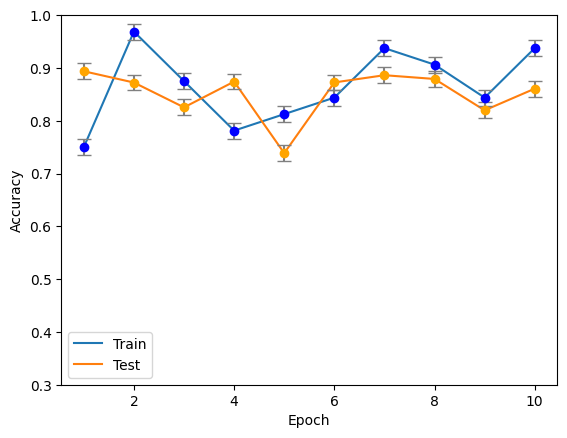

In [58]:
plt.plot(range(1, 11), train_accuracies, label='Train')
plt.plot(range(1, 11), test_accuracies, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend()

for epoch, (train_acc, test_acc) in enumerate(zip(train_accuracies, test_accuracies), 1):
    plt.errorbar(epoch, train_acc, yerr=margin_of_error, fmt='o', color='blue', ecolor='gray', capsize=5)
    plt.errorbar(epoch, test_acc, yerr=margin_of_error, fmt='o', color='orange', ecolor='gray', capsize=5)

plt.show()